In [57]:
import numpy as np 
import pandas as pd
import seaborn as sns
import time
import os

from scipy import stats

# plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot

# matplotlib
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression

# Data Loading

In [58]:
INPUT_FOLDER = './data/'

df = pd.read_csv(os.path.join(INPUT_FOLDER, 'bank/bank-full.csv'), sep=";")
# bank_additional_df = pd.read_csv(os.path.join(INPUT_FOLDER, 'bank-additional/bank-additional.csv'), sep=";")

# Data analysis and feature enginering

Let's start by understanding the structure of the data.

In [59]:
# Get to know the dataframe better

cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

# Types of columns
print(f"Number of 'df' columns is: {cols.shape[0]}")
print(f"Number of 'df' numerical columns is: {num_cols.shape[0]}")
print(f"Number of 'df' categorical columns is: {len(cat_cols)}")

# print(df.select_dtypes(include='object').shape[1])

df.head()

Number of 'df' columns is: 17
Number of 'df' numerical columns is: 7
Number of 'df' categorical columns is: 10


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Feature engineering 

### Missing values
Let's see how many missing values we have.

In [60]:
missing_data = df.isnull().sum()
# print(missing_data[missing_data > 0])
# print(f"We compare these values to the row number {df.shape[0]}")

# % of missing values
print(f"{round(missing_data.sum() / np.product(df.shape), 2)}% of missing values.")

0.0% of missing values.


### Encoding categorical variables
We use ordinal encoding!

In [61]:
ordinal_encoder = OrdinalEncoder()
df[cat_cols] = ordinal_encoder.fit_transform(df[cat_cols])

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,2.0,5,8.0,261,1,-1,0,3.0,0.0
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,2.0,5,8.0,151,1,-1,0,3.0,0.0
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,2.0,5,8.0,76,1,-1,0,3.0,0.0
3,47,1.0,1.0,3.0,0.0,1506,1.0,0.0,2.0,5,8.0,92,1,-1,0,3.0,0.0
4,33,11.0,2.0,3.0,0.0,1,0.0,0.0,2.0,5,8.0,198,1,-1,0,3.0,0.0


# Simple Linear Regression

In [62]:
# Separate target from predictors
y = df.y
X = df.drop(['y'], axis=1)

* Mutual information

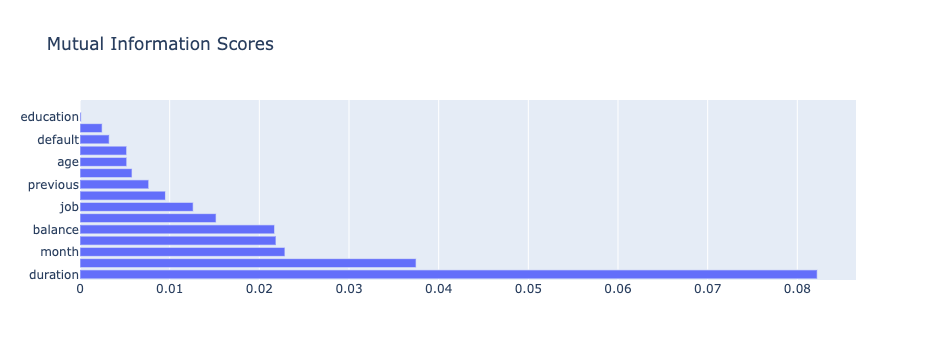

In [63]:
# compute mi_score for all features
mi_score = mutual_info_regression(X, y)
mi_score = pd.Series(mi_score, name="MI Score", index=X.columns)\
                .sort_values(ascending=False)

# plot mi_score
ticks = list(mi_score.index)

fig = go.Figure(go.Bar(
            x=mi_score,
            y=ticks,
            orientation='h'))

fig.update_layout(title="Mutual Information Scores")

fig.show()

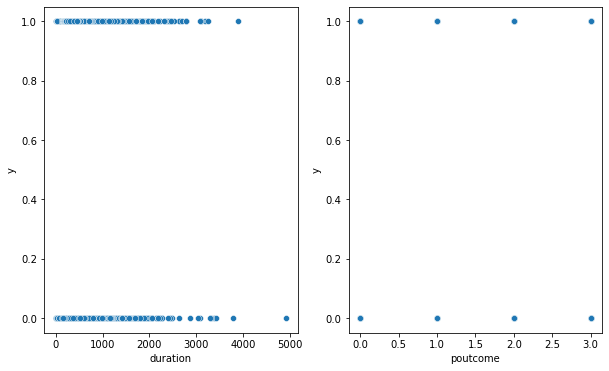

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# highest correlation is with "OverallQual". We added "GrLivArea" as well.
g1 = sns.scatterplot(x="duration", y="y", data=df, ax=axes[0]);
g2 = sns.scatterplot(x="poutcome", y="y", data=df, ax=axes[1]);

The mutual information score is very low. As we can see, the ```"duration"``` feature which scores the most doesn't seem to have a visual correlation with the target ```"y"```. The next high scoring MI ```"poutcome"``` seems completely irrelevant.

# Linear Model

In [65]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [66]:
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [67]:
y_prediction = LR.predict(x_test)
y_prediction

array([-0.00451858,  0.05441237,  0.07716226, ..., -0.01190252,
       -0.07813874,  0.06306538])

In [68]:
# predicting the accuracy score
score = r2_score(y_test, y_prediction)
print('r2 socre is ',score)
print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

r2 socre is  0.21614195871100383
mean_sqrd_error is== 0.0831598080560941
root_mean_squared error of is== 0.28837442337366553
